# Use a CNN to recognize sounds

This notebook contains all the code you need to use an existing (pre-trained) OpenSoundscape convolutional neural network model (CNN) to make predictions on your own data - for instance, to detect the song or call of an animal the CNN has been trained to recognize. It asssumes that you already have access to a CNN that has been trained to recognize the sound of interest. 

To find publicly available pre-trained CNNs, check out the [Bioacoustics Model Zoo](https://github.com/kitzeslab/bioacoustics-model-zoo/tree/main). 

If you are interested in training your own CNN, see the other tutorials at [opensoundscape.org](https://opensoundscape.org) related to model training. 

Before running this tutorial, install OpenSoundscape by following the instructions on the OpenSoundscape website, [opensoundscape.org](http://opensoundscape.org/). More detailed tutorials about data preprocessing, training CNNs, and customizing prediction methods can also be found on this site.


## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/predict_with_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/predict_with_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [1]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install git+https://github.com/kitzeslab/opensoundscape@develop ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0

### package imports

The `cnn` module provides a function `load_model` to load saved opensoundscape models

In [2]:
from opensoundscape.ml.cnn import load_model
from opensoundscape import Audio
import opensoundscape

load some additional packages and perform some setup for the Jupyter notebook.

In [3]:
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [4]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

### Load a model

Models can be loaded either from a local file (`load_model(file_path)`) or directly from the [Bioacoustics Model Zoo](https://github.com/kitzeslab/bioacoustics-model-zoo/tree/main) like this:

In [1]:
from opensoundscape.ml import bioacoustics_model_zoo as bmz

# list available models from the model zoo
bmz.list_models()

Using cache found in /Users/SML161/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


['HawkEars', 'rana_sierrae_cnn']

In [7]:
# load a model that recognizes the calls of Rana sierrae (Sierra Nevada yellow-legged frog)
model = opensoundscape.ml.bioacoustics_model_zoo.load('rana_sierrae_cnn')

In [8]:
model.network.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.2014e-02, -1.2387e-02,  8.3130e-04,  ...,  6.4412e-02,
                          1.7465e-02, -8.0509e-03],
                        [ 8.8050e-03, -1.6217e-06, -1.0693e-01,  ..., -2.6153e-01,
                         -1.2673e-01,  6.6321e-03],
                        [-8.9521e-03,  4.8324e-02,  2.9161e-01,  ...,  5.1529e-01,
                          2.5064e-01,  6.3686e-02],
                        ...,
                        [-3.3456e-02,  3.3444e-03,  7.0153e-02,  ..., -3.2413e-01,
                         -4.1281e-01, -2.5398e-01],
                        [ 2.5187e-02,  2.9105e-02,  6.1438e-02,  ...,  4.0891e-01,
                          3.8712e-01,  1.6014e-01],
                        [-2.0792e-02, -1.5926e-02, -2.3352e-02,  ..., -1.4412e-01,
                         -8.1764e-02, -8.6216e-03]],
              
                       [[-1.1698e-02, -3.2263e-02, -3.1381e-02,  ...,  4.0807e-02,
                          1.2624

#### Save model to file
If you wish to save the model to a local file, simply use `.save()`:

In [9]:
model.save('rana_sierrae_cnn.model')

#### Load a CNN from a local file
loading a CNN from a local file using the `opensoundscape.cnn.load_model` function:

In [10]:
model = load_model('./rana_sierrae_cnn.model')

/Users/SML161/opensoundscape/opensoundscape/preprocess/actions.py:497: UserWarning: Overlay class's .overlay_df will be None after loading from dict and `.criterion_fn` will be always_true(). Reset these attributes and set .bypass to False to use Overlay after loading with from_dict().
  warnings.warn(


### Choose audio files for prediction

Create a list of audio files to predict on. They can be of any length. Consider using `glob` to find many files at once.

For this example, let's download a 1-minute audio clip:

In [26]:
url = 'https://tinyurl.com/birds60s'
Audio.from_url(url).save('./1min.wav')

use glob to create a list of all files matching a pattern in a folder:

In [27]:
from glob import glob 
audio_files = glob('./*.wav') #match all .wav files in the current directory
audio_files

['./1min.wav']

## generate predictions with the model
The model returns a dataframe with a MultiIndex of file, start_time, and end_time. There is one column for each class. 

The values returned by the model range from -infinity to infinity (theoretically), and higher scores mean the model is more confident the class (song/species/sound type) is present in the audio clip.

In [28]:
scores = model.predict(audio_files)
scores.head()

  0%|          | 0/30 [00:00<?, ?it/s]

rana_sierrae  negative
file       start_time end_time                        
./1min.wav 0.0        2.0           0.639482 -1.437535
           2.0        4.0          -0.608044  0.075410
           4.0        6.0          -1.708590  0.716553
           6.0        8.0          -1.420078  0.417351
           8.0        10.0         -2.448119  1.788549

## Overlapping prediction clips

In [29]:
model.preprocessor.pipeline.to_tensor.set(use_skimage=True)

In [30]:
scores = model.predict(audio_files, overlap_fraction=0.5) #reproduce
scores.head()

/Users/SML161/opensoundscape/opensoundscape/ml/dataloaders.py:83: DeprecationWarning: `overlap_fraction` argument is deprecated and will be removed in a future version. Use `clip_overlap_fraction` instead.
  warnings.warn(


  0%|          | 0/59 [00:00<?, ?it/s]

rana_sierrae  negative
file       start_time end_time                        
./1min.wav 0.0        2.0           0.639482 -1.437535
           1.0        3.0           0.145084 -0.871671
           2.0        4.0          -0.608044  0.075410
           3.0        5.0           1.121938 -1.763479
           4.0        6.0          -1.708590  0.716553

## Inspect samples generated during prediction

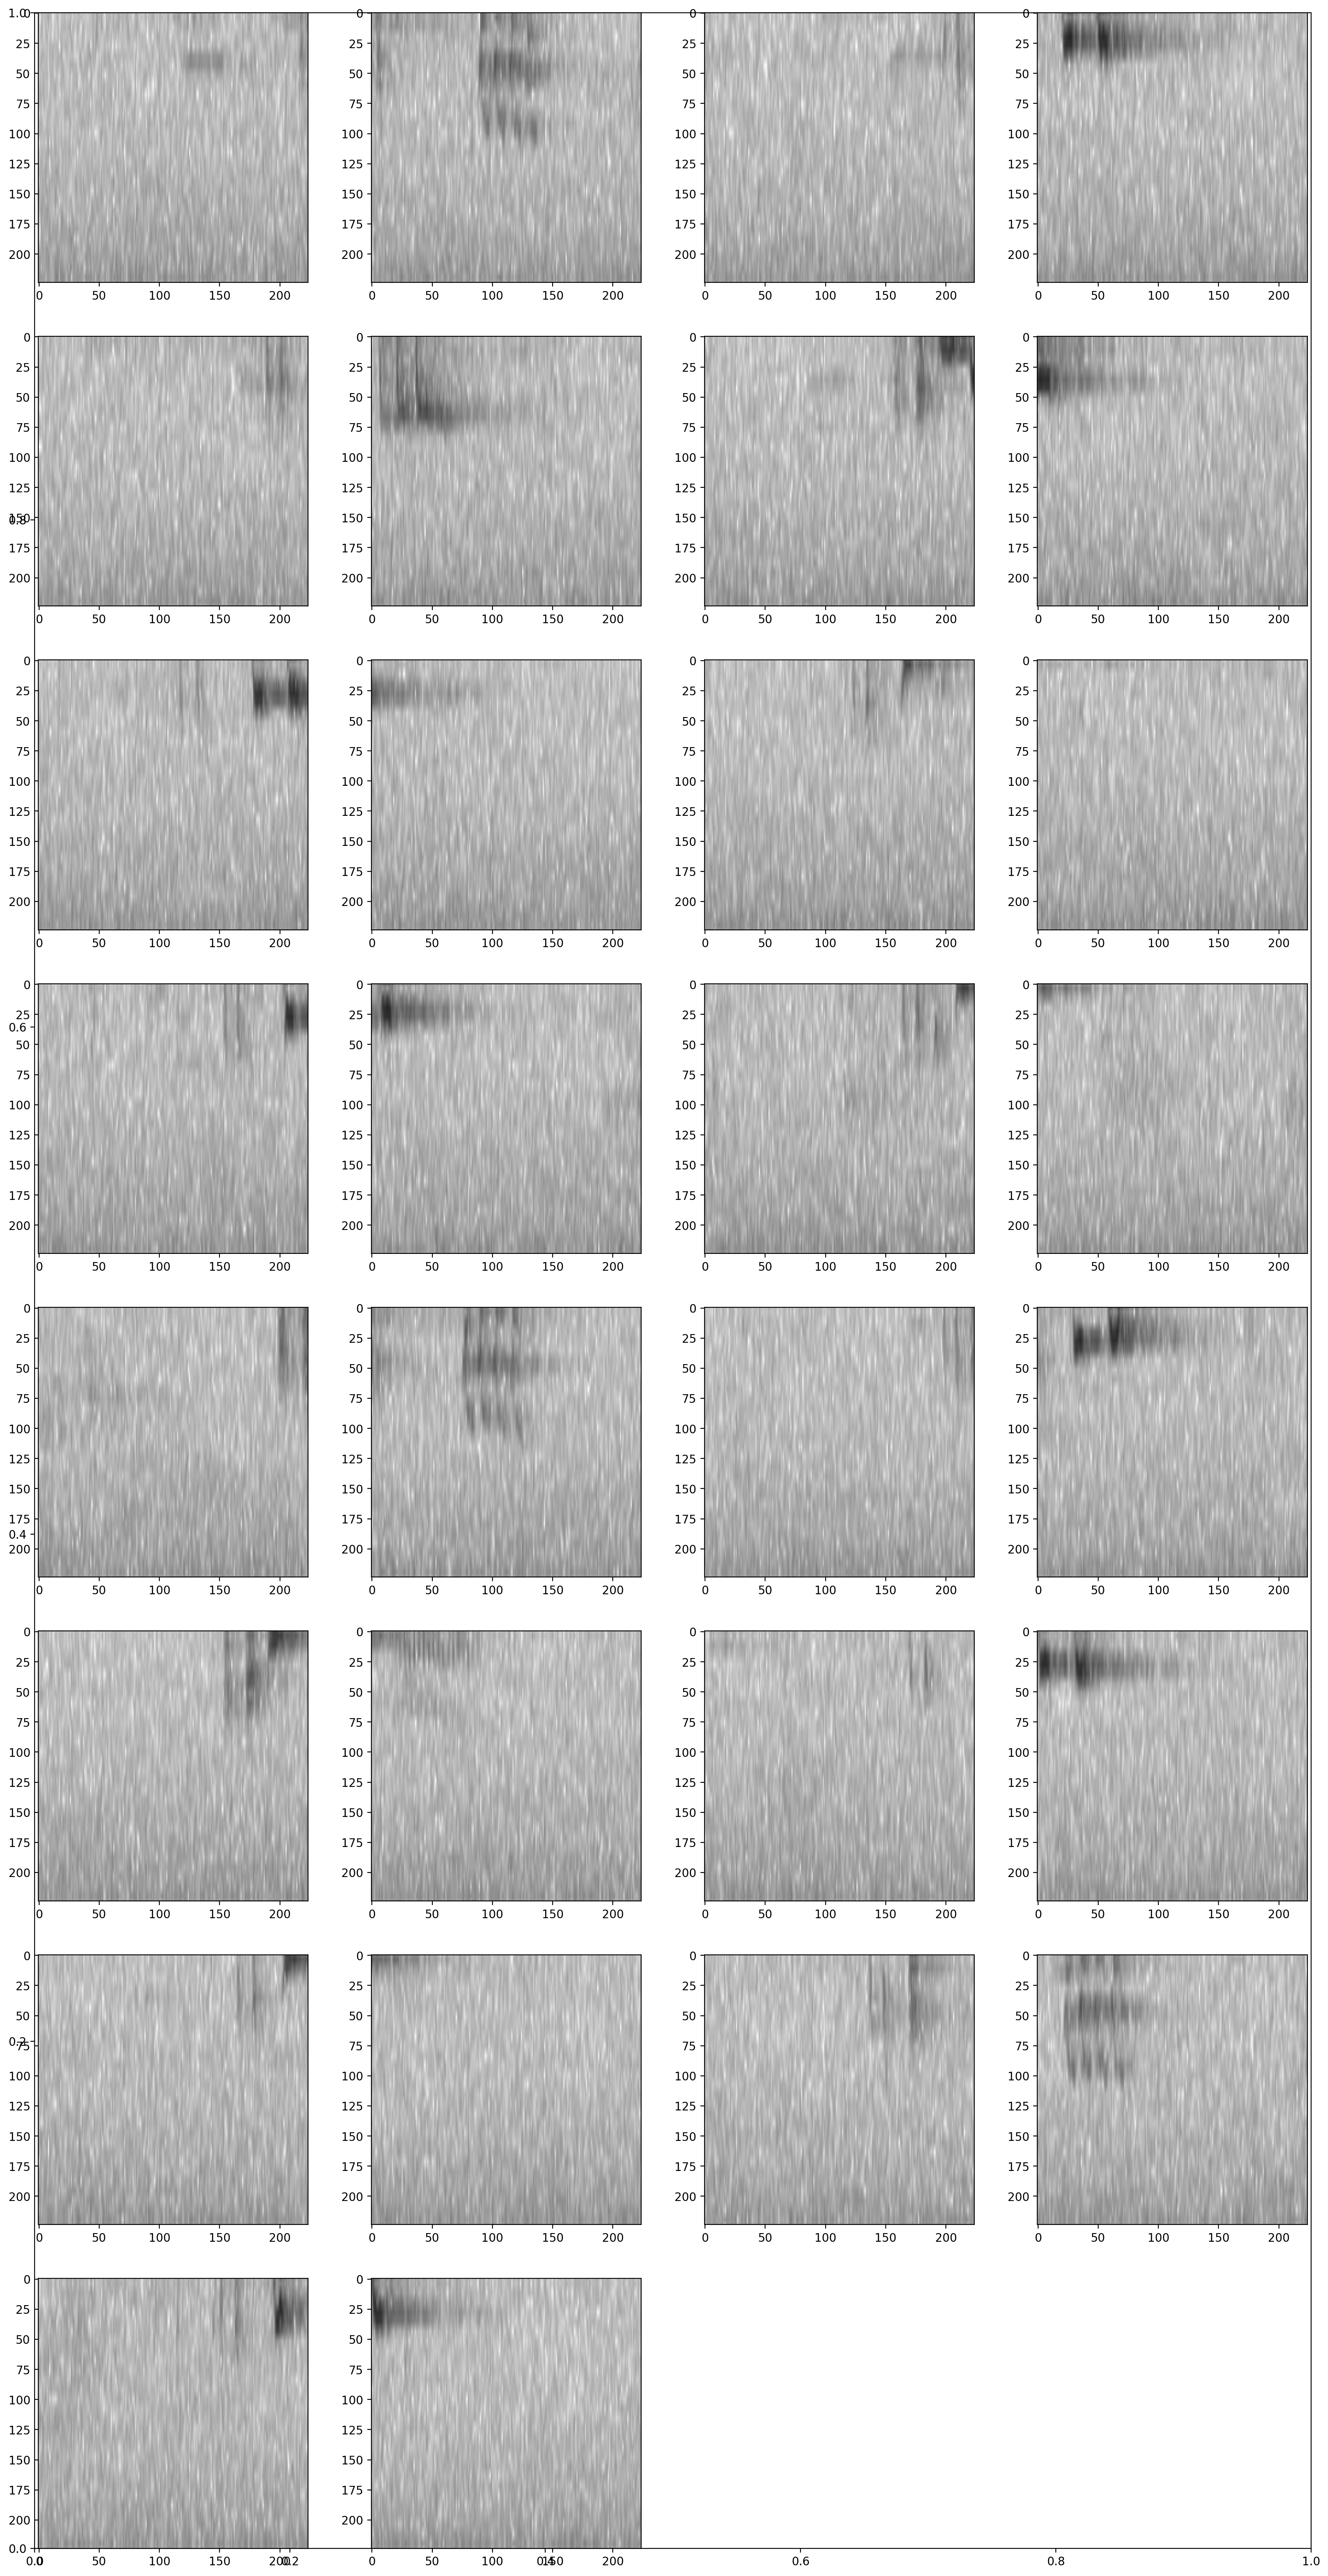

In [31]:
from opensoundscape.preprocess.utils import show_tensor_grid
from opensoundscape.ml.datasets import AudioSplittingDataset

#generate a dataset with the samples we wish to generate and the model's preprocessor
inspection_dataset = AudioSplittingDataset(audio_files, model.preprocessor) 
inspection_dataset.bypass_augmentations = True

samples = [sample.data for sample in inspection_dataset]
_ = show_tensor_grid(samples,4,invert=True)

## Options for prediction

The code above returns the raw predictions of the model without any post-processing (such as a softmax layer or a sigmoid layer). 

For details on how to post-processing prediction scores and to generate binary 0/1 predictions of class presence, see the "Basic training and prediction with CNNs" tutorial notebook. But, as a quick example here, let's add a softmax layer to make the prediction scores for both classes sum to 1. 

We can also convert our continuous scores into True/False (or 1/0) predictions for the presence of each class in each sample. Think about whether each clip should be labeled with only one class (use `metrics.predict_single_target_labels`) or whether each clip could contain zero, one, or multiple classes (use `metrics.predict_multi_target_labels`)

As before, the `scores` are continuous variables, but now have been softmaxed:

In [33]:
scores.head()

rana_sierrae  negative
file       start_time end_time                        
./1min.wav 0.0        2.0           0.888649  0.111351
           2.0        4.0           0.335491  0.664509
           4.0        6.0           0.081275  0.918725
           6.0        8.0           0.137356  0.862644
           8.0        10.0          0.014250  0.985750

Now let's use the `predict_single_target_labels(scores)` function to label the highest scoring class 1 for each sample, and other classes 0. 

In [34]:
from opensoundscape.metrics import predict_single_target_labels
predicted_labels = predict_single_target_labels(scores)
predicted_labels.head()

rana_sierrae  negative
file       start_time end_time                        
./1min.wav 0.0        2.0                  1         0
           2.0        4.0                  0         1
           4.0        6.0                  0         1
           6.0        8.0                  0         1
           8.0        10.0                 0         1

It is sometimes helpful to look at a histogram of the scores:

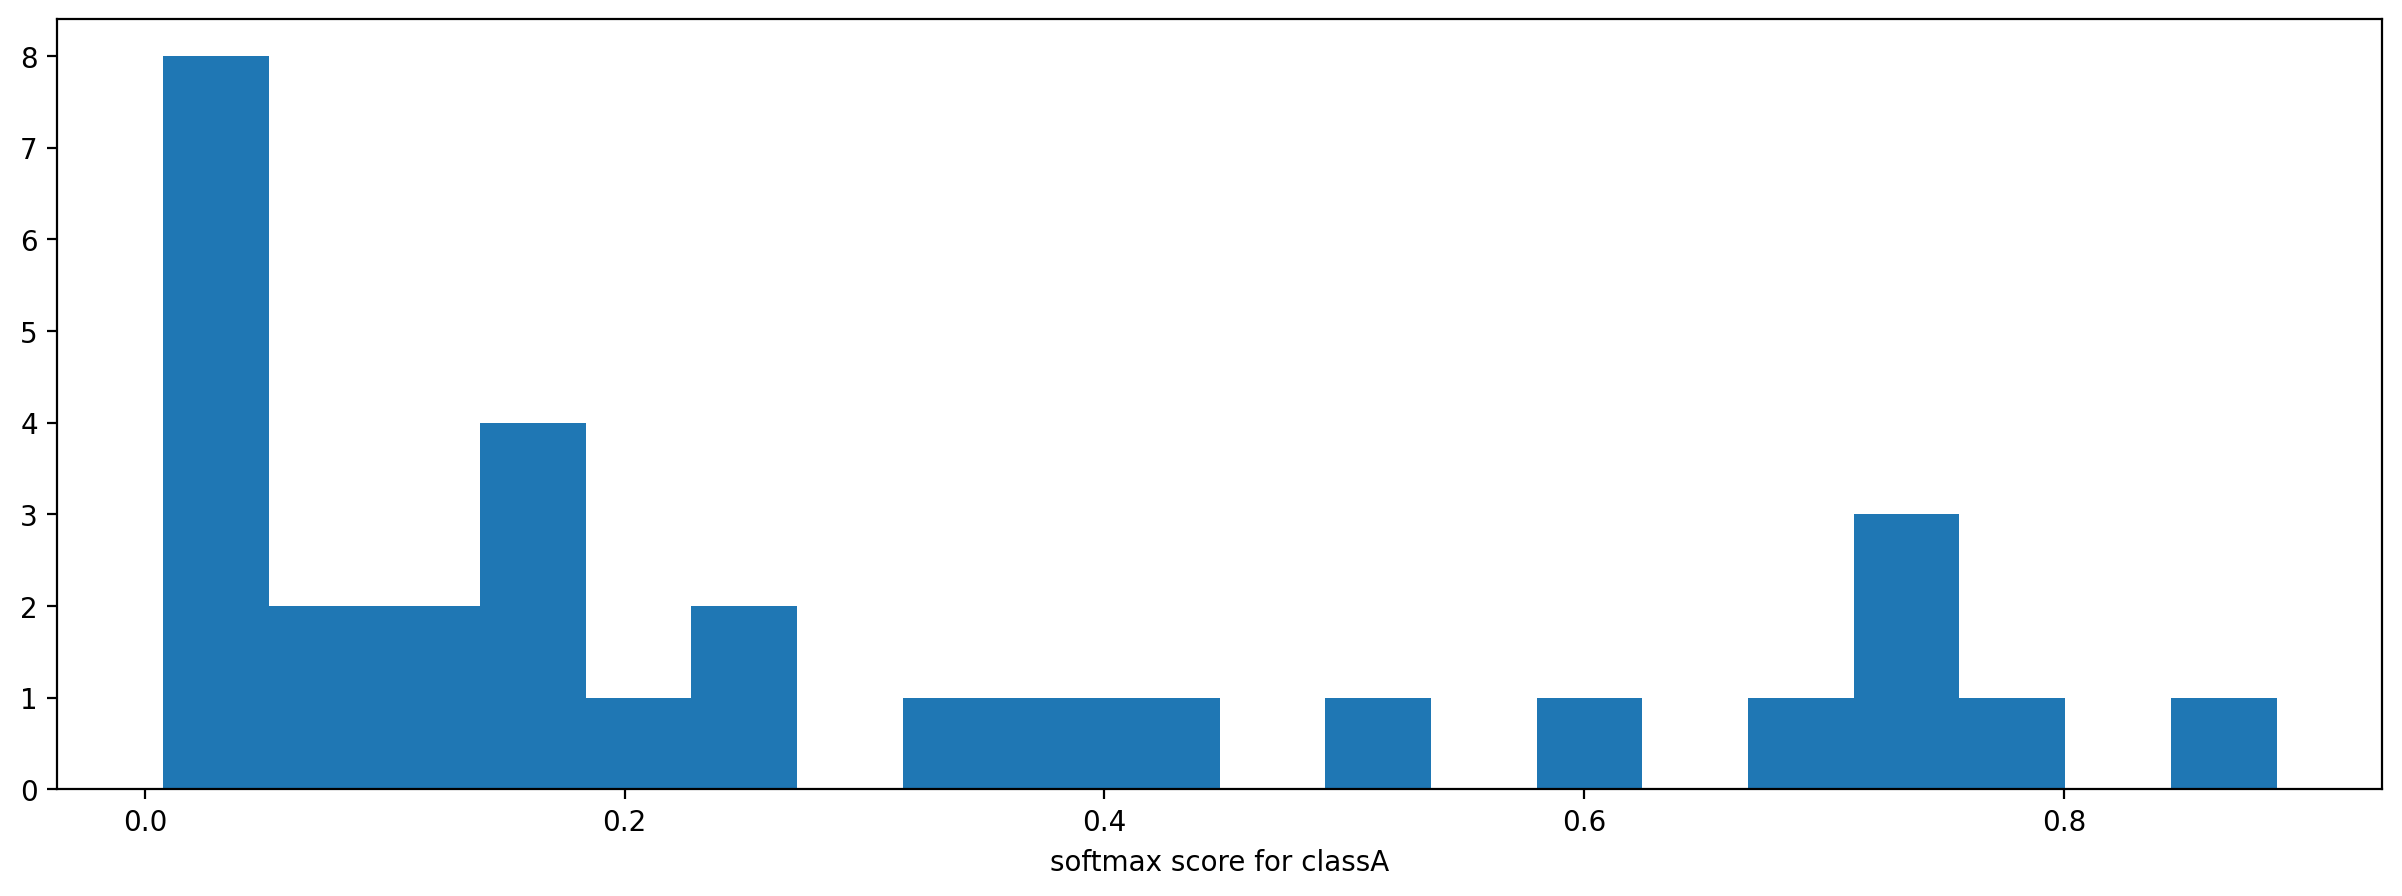

In [35]:
_ = plt.hist(scores['rana_sierrae'],bins=20)
_ = plt.xlabel('softmax score for classA')

## Using models trained in older OpenSoundscape versions

#### Using models from OpenSoundscape >=0.11.0

Simply load the model with `opensoundscape.ml.cnn.load_model(path)`. 

Starting with OpenSoundscape 0.11.0, the default model.save() (for CNN/SpectroramClassifier) is designed to work smoothly across package version updates: the default behavior (pickle=False) saves a state dictionary for the network parameters and a dictionary describing the preprocessing settings, as well as some other information (class list, architecture name, etc) which OpenSoundscape can use to re-create the model from the saved file so long as any custom code used to create the model/preprocessor is still available when loading the model from a file. 

#### Using models from OpenSoundscape <0.11.0

In general, if you want to use a model created in an OpenSoundscape <0.11.0 in a newer version, you should:


1. use or re-create a separate Python environment (eg, conda environment) that has the same version of OpenSoundscape used to create and train the model. 


2. Save the model's weights like this: 
```
torch.save({'weights':model.network.state_dict(),'my_weights.pt'})
```


3. You'll also want to save/take note of the architecture, ordered list of model classes, and sample input shape, and all preprocessing parameters/steps (e.g. sample shape, spectrogram creation parameters, scaling/normalization).


4. Then, in your new opensoundscape environment, recreate the model with the same architecture, input shape, class list, and preprocessing parameters

5. Load the saved weights into the model architecture:

```
weights = torch.load('my_weights.pt')['weights']
my_new_model.network.load_state_dict(weights)
```

#### Changes to default preprocessing behavior across OpenSoundscape versions
Be aware of changes to default preprocessing settings between OpenSoundscape versions. In particular: 
- opensoundscape<0.7.0 used the opposite sign convention in preprocessed tensor samples: loud sounds were low values and quiet sounds were high values. Specify `model.preprocessor.pipeline.to_tensor.set(invert=True)` to match the default preprocessor behavior of opensoundscape<0.7.0
- opensoundscape<0.11.0 used skimage interpolation by default in Spectrogram.to_tensor(which is used in the SpectrogramPreprocessor.pipeline.to_tensor action), while newer version use pytorch interpolation by default (much faster). The differences in interpolation methods are subtle but lead to slightly different ML model scores. Specify `model.preprocessor.pipeline.to_tensor.set(use_skimage=True)` to match the default preprocessor behavior of opensoundscape<0.11.0. 

If you need assistance loading a model developed in a different OpenSoundscape version into a more recent version, please contact one of the developers of OpenSoundscape. 

### Clean up: delete model objects

In [36]:
from pathlib import Path
for p in Path('.').glob('*.model'):
    p.unlink()
Path('1min.wav').unlink()